## M6A Analysis Final Part

Put everything else in this notebook.

## Relationship between Gene Expression and M6A level


In [1]:
group_dict = {
    'NH': ['NH_1','NH_2','NH_3','NH_4','NH_5','NH_6','NH_7','NH_8','NH_9','NH_10','NH_11','NH_12',],
    'AH': ['LV_01', 'LV_02', 'LV_03', 'LV_04', 'LV_05', 'LV_06', 'LV_07', 'LV_08','LV_09','LV_10', 'RV_01', 'RV_02', 'RV_03', 'RV_04', 'RV_05', 'RV_06', 'RV_07', 'RV_08','RV_09','RV_10'],
    'NK': ['P1_NKI_1', 'P1_NKI_2', 'P1_NKI_3', 'P1_NKI_4','P1_NKI_5','P1_NKI_6','P1_NKI_7','P1_NKI_8','P1_NKI_9','P1_NKI_10','P1_NKI_11','P1_NKI_12',],
    'AK': ['M_KI_01', 'M_KI_02', 'M_KI_03', 'M_KI_04', 'M_KI_05','F_KI_06', 'F_KI_07', 'F_KI_08', 'F_KI_09', 'F_KI_10',]
}

In [2]:
import pandas as pd
peak_intensity = pd.read_table('../_data/m6A/parsed_peaks/peak_intensity.csv', index_col=0)
peak_to_gene = pd.read_table('../_data/m6A/parsed_peaks/peak_to_gene.txt', index_col=0)
peak_to_gene.index = [x.replace('-', ':') for x in peak_to_gene.index.values]

Compute the average peak intensity for each group

In [3]:
import numpy as np
peak_mean_intes = pd.DataFrame(columns=['NH', 'AH', 'NK', 'AK'], index=peak_intensity.index)
for group in peak_mean_intes.columns.values:
    peak_mean_intes[group] = peak_intensity[group_dict[group]].mean(axis=1)

peak_mean_intes = np.log2(peak_mean_intes)

### Heart Age
Because the gene expression fold-change is computed as AH/NH (see Analysis Part 1: Differential Gene Expression Analysis with DESeq2), we need to keep the order identical when computing for peak fold-change.

In [4]:
gene_expr_foldchange_heart = pd.read_table('../_data/m6A/deseq/Heart_Age.txt')
peak_foldchange_heart = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)

In [5]:
peak_foldchange_heart['peak_fc'] = peak_mean_intes['AH'] - peak_mean_intes['NH']
peak_foldchange_heart['gene'] = peak_to_gene.loc[peak_foldchange_heart.index, 'gene']

In [6]:
peak_foldchange_heart['gene_fc'] = [gene_expr_foldchange_heart.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_heart.index else np.nan 
                              for x in peak_foldchange_heart['gene'] ]

In [7]:
peak_foldchange_heart.head()

,peak_fc,gene,gene_fc
chr12:109612940:109613040,0.053305,ENSMUSG00000097451,NaN
chr12:4880532:4880632,0.441228,ENSMUSG00000020634,1.590420
chr14:75906737:75906837,-0.168853,ENSMUSG00000067995,-0.135701
chr11:86502571:86502671,0.766745,ENSMUSG00000020516,-0.064094
chr11:28576885:28576985,-0.035175,ENSMUSG00000032878,1.046173


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_heart.peak_fc, peak_foldchange_heart.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#sns.jointplot(x=peak_foldchange_heart.peak_fc, y=peak_foldchange_heart.gene_fc, kind='kde', color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_heart.peak_fc, y=peak_foldchange_heart.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Heart Age (AH/NH), Spearmanr=%.2f'%(corr))
plt.savefig('Heart_Age.pdf')

### Kidney Age
Now do the same thing for Kidney Age. Note that Kidney gene expression fold-change is computed as Adult Kidney / Neonatal Kidney.

In [9]:
gene_expr_foldchange_kidney = pd.read_table('../_data/m6A/deseq/Kidney_Age.txt')
peak_foldchange_kidney = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_kidney['peak_fc'] = peak_mean_intes['AK'] - peak_mean_intes['NK']
peak_foldchange_kidney['gene'] = peak_to_gene.loc[peak_foldchange_kidney.index, 'gene']
peak_foldchange_kidney['gene_fc'] = [gene_expr_foldchange_kidney.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_kidney.index else np.nan 
                              for x in peak_foldchange_kidney['gene'] ]

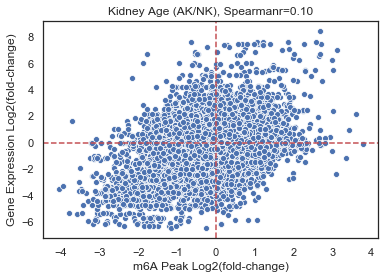

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_kidney.peak_fc, peak_foldchange_kidney.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
#sns.jointplot(x=peak_foldchange.peak_fc, y=peak_foldchange.gene_fc, kind='kde', color="skyblue")
ax = sns.scatterplot(x=peak_foldchange_kidney.peak_fc, y=peak_foldchange_kidney.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Kidney Age (AK/NK), Spearmanr=%.2f'%(corr))
plt.savefig('Kidney_Age.pdf')

### Adult Heart vs Adult Kidney
The comparison on Gene expression was done in the order of AH vs AK.

In [11]:
gene_expr_foldchange_ahk = pd.read_table('../_data/m6A/deseq/AHK.txt')
peak_foldchange_ahk = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_ahk['peak_fc'] = peak_mean_intes['AH'] - peak_mean_intes['AK']
peak_foldchange_ahk['gene'] = peak_to_gene.loc[peak_foldchange_ahk.index, 'gene']
peak_foldchange_ahk['gene_fc'] = [gene_expr_foldchange_ahk.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_ahk.index else np.nan 
                              for x in peak_foldchange_ahk['gene'] ]

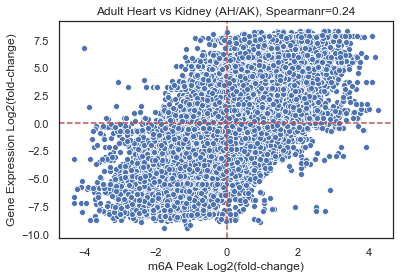

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_ahk.peak_fc, peak_foldchange_ahk.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
ax = sns.scatterplot(x=peak_foldchange_ahk.peak_fc, y=peak_foldchange_ahk.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Adult Heart vs Kidney (AH/AK), Spearmanr=%.2f'%(corr))
plt.savefig('AHK.pdf')

### Neonatal Heart vs Adult Kidney
The comparison on Gene expression was done in the order of NH vs NK.

In [13]:
gene_expr_foldchange_nhk = pd.read_table('../_data/m6A/deseq/NHK.txt')
peak_foldchange_nhk = pd.DataFrame(columns=['peak_fc', 'gene', 'gene_fc'], index=peak_mean_intes.index)
peak_foldchange_nhk['peak_fc'] = peak_mean_intes['NH'] - peak_mean_intes['NK']
peak_foldchange_nhk['gene'] = peak_to_gene.loc[peak_foldchange_nhk.index, 'gene']
peak_foldchange_nhk['gene_fc'] = [gene_expr_foldchange_nhk.loc[x, 'log2FoldChange'] if x in gene_expr_foldchange_nhk.index else np.nan 
                              for x in peak_foldchange_nhk['gene'] ]

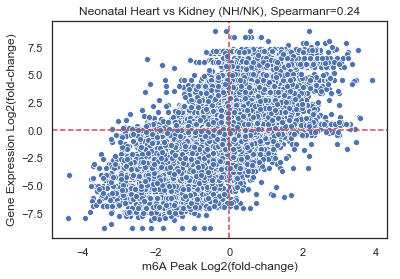

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
corr = ss.spearmanr(peak_foldchange_nhk.peak_fc, peak_foldchange_nhk.gene_fc, nan_policy='omit').correlation
plt.clf()
sns.set(style="white", color_codes=True)
ax = sns.scatterplot(x=peak_foldchange_nhk.peak_fc, y=peak_foldchange_nhk.gene_fc)
ax.axvline(x=0, color='r', linestyle='--')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('m6A Peak Log2(fold-change)')
ax.set_ylabel('Gene Expression Log2(fold-change)')
ax.set_title('Neonatal Heart vs Kidney (NH/NK), Spearmanr=%.2f'%(corr))
plt.savefig('NHK.pdf')